In [1]:
import os

def count_videos(root_dir):
    total = 0
    for cls in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        # Count subdirectories (each subdirectory is a video folder)
        num_videos = sum(
            1 for sub in os.listdir(cls_path)
            if os.path.isdir(os.path.join(cls_path, sub))
        )
        print(f"{cls}: {num_videos} videos")
        total += num_videos
    return total

train_root = r"C:\Users\rayaa\Downloads\ucf_crime\Train"
test_root = r"C:\Users\rayaa\Downloads\ucf_crime\Test"

train_count = count_videos(train_root)
test_count = count_videos(test_root)

print(f"\nTotal Train videos: {train_count}")
print(f"Total Test videos: {test_count}")


Abuse: 48 videos
Arrest: 45 videos
Arson: 41 videos
Assault: 47 videos
Burglary: 87 videos
Explosion: 29 videos
Fighting: 45 videos
NormalVideos: 800 videos
RoadAccidents: 127 videos
Robbery: 145 videos
Shooting: 27 videos
Shoplifting: 29 videos
Stealing: 95 videos
Vandalism: 45 videos
Abuse: 2 videos
Arrest: 5 videos
Arson: 9 videos
Assault: 3 videos
Burglary: 13 videos
Explosion: 21 videos
Fighting: 5 videos
NormalVideos: 150 videos
RoadAccidents: 23 videos
Robbery: 5 videos
Shooting: 23 videos
Shoplifting: 21 videos
Stealing: 5 videos
Vandalism: 5 videos

Total Train videos: 1610
Total Test videos: 290


# Imports
---

In [2]:
import os, glob, random, torch, shutil
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from torch.optim import AdamW
from transformers import AutoImageProcessor, VideoMAEForVideoClassification
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Dataset
---

In [3]:
class UCFCrimeClipDataset(Dataset):
    def __init__(self, root_dir, clip_len=16, image_processor=None, downsample_normal=None):
        self.root_dir = root_dir
        self.clip_len = clip_len
        self.image_processor = image_processor
        self.samples = []

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(classes)}

        for cls in classes:
            cls_path = os.path.join(root_dir, cls)
            video_folders = [vf for vf in os.listdir(cls_path) if os.path.isdir(os.path.join(cls_path, vf))]

            # Downsample NormalVideos if requested
            if downsample_normal is not None and "Normal" in cls:
                video_folders = random.sample(video_folders, min(downsample_normal, len(video_folders)))

            for video_folder in video_folders:
                video_path = os.path.join(cls_path, video_folder)
                self.samples.append((video_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = sorted(glob.glob(os.path.join(video_path, "*.png")))
        if len(frames) == 0:
            raise RuntimeError(f"No frames found in {video_path}")

        # Sample clip_len frames (random or pad)
        if len(frames) >= self.clip_len:
            indices = sorted(random.sample(range(len(frames)), self.clip_len))
        else:
            indices = list(range(len(frames))) + [len(frames) - 1] * (self.clip_len - len(frames))

        clip = [Image.open(frames[i]).convert("RGB") for i in indices]
        pixel_values = self.image_processor(clip, return_tensors="pt")["pixel_values"]
        pixel_values = pixel_values.squeeze(0)  # [C, T, H, W]
        return pixel_values, label

# Paths & Setup
---

In [4]:
train_root = r"C:\Users\rayaa\Downloads\ucf_crime\Train"
test_root = r"C:\Users\rayaa\Downloads\ucf_crime\Test"
num_classes = len(os.listdir(train_root))

base_model_name = "MCG-NJU/videomae-base"
image_processor = AutoImageProcessor.from_pretrained(base_model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# Model
---

In [5]:
model = VideoMAEForVideoClassification.from_pretrained(
    base_model_name,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Data Loaders
---

In [6]:
# Downsample NormalVideos to 150
train_dataset = UCFCrimeClipDataset(train_root, clip_len=16, image_processor=image_processor, downsample_normal=150)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

test_dataset = UCFCrimeClipDataset(test_root, clip_len=16, image_processor=image_processor)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 960, Test samples: 290


# Training Loop
---

In [7]:
checkpoint_dir = r"C:\Users\rayaa\Downloads\ucf_crime\crime_type_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

epochs = 10
save_every = 1  # save checkpoint every N epochs

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for clips, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        clips, labels = clips.to(device).float(), labels.to(device)
        outputs = model(pixel_values=clips)
        logits = outputs.logits
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        _, preds = logits.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss/total:.4f} - Acc: {correct/total:.4f}")

    # Checkpoint
    if (epoch + 1) % save_every == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        print(f"💾 Saved checkpoint: {checkpoint_path}")

Epoch 1/10: 100%|██████████| 480/480 [52:01<00:00,  6.50s/it]


Epoch [1/10] - Loss: 2.5110 - Acc: 0.1635
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\crime_type_checkpoints\epoch_1.pt


Epoch 2/10: 100%|██████████| 480/480 [1:07:52<00:00,  8.48s/it]


Epoch [2/10] - Loss: 2.3565 - Acc: 0.2135
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\crime_type_checkpoints\epoch_2.pt


Epoch 3/10: 100%|██████████| 480/480 [1:09:05<00:00,  8.64s/it]


Epoch [3/10] - Loss: 2.1815 - Acc: 0.2760
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\crime_type_checkpoints\epoch_3.pt


Epoch 4/10: 100%|██████████| 480/480 [1:09:11<00:00,  8.65s/it]


Epoch [4/10] - Loss: 2.0343 - Acc: 0.3260
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\crime_type_checkpoints\epoch_4.pt


Epoch 5/10: 100%|██████████| 480/480 [1:10:11<00:00,  8.77s/it]


Epoch [5/10] - Loss: 1.7944 - Acc: 0.4313
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\crime_type_checkpoints\epoch_5.pt


Epoch 6/10: 100%|██████████| 480/480 [1:08:31<00:00,  8.57s/it]


Epoch [6/10] - Loss: 1.5320 - Acc: 0.5073
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\crime_type_checkpoints\epoch_6.pt


Epoch 7/10: 100%|██████████| 480/480 [1:14:16<00:00,  9.28s/it]


Epoch [7/10] - Loss: 1.2688 - Acc: 0.5979
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\crime_type_checkpoints\epoch_7.pt


Epoch 8/10: 100%|██████████| 480/480 [1:15:15<00:00,  9.41s/it]


Epoch [8/10] - Loss: 1.0075 - Acc: 0.6750
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\crime_type_checkpoints\epoch_8.pt


Epoch 9/10: 100%|██████████| 480/480 [1:20:44<00:00, 10.09s/it]


Epoch [9/10] - Loss: 0.8307 - Acc: 0.7438
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\crime_type_checkpoints\epoch_9.pt


Epoch 10/10: 100%|██████████| 480/480 [1:20:06<00:00, 10.01s/it]


Epoch [10/10] - Loss: 0.5898 - Acc: 0.8208
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\crime_type_checkpoints\epoch_10.pt


# Evaluation
---

Evaluating: 100%|██████████| 145/145 [03:31<00:00,  1.46s/it]


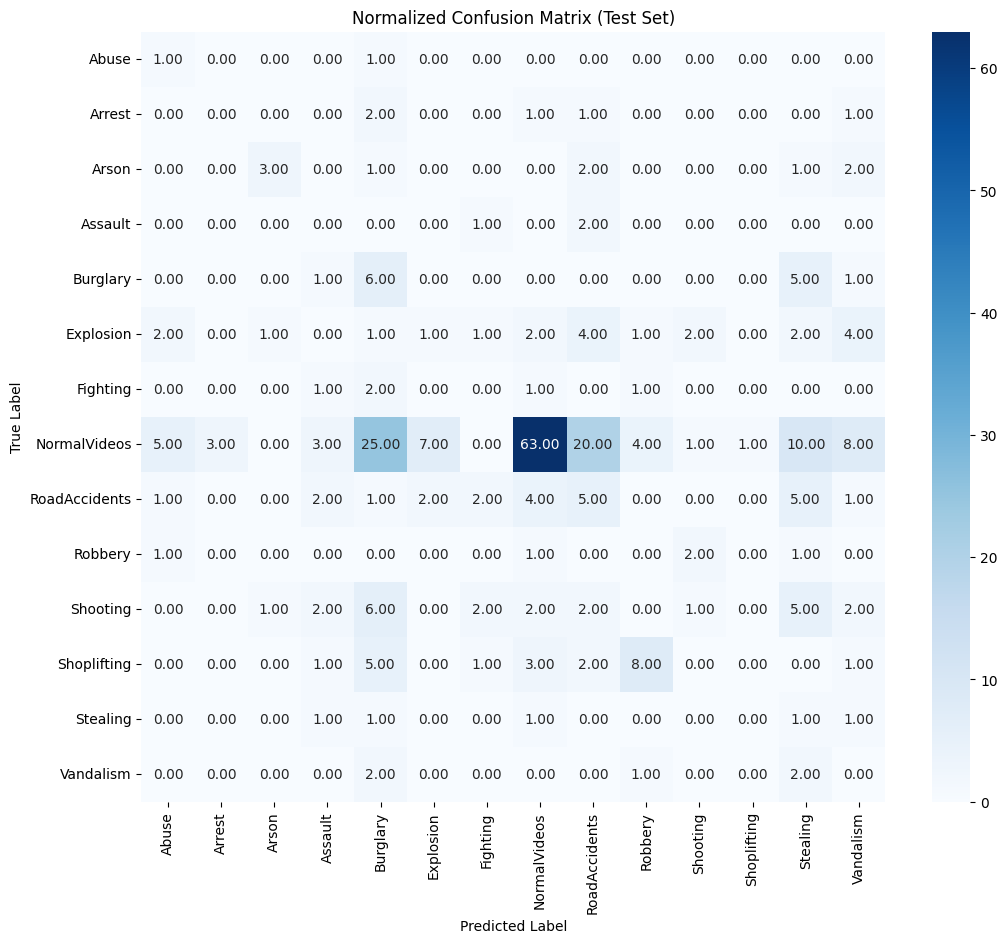


Classification Report (Test Set):
               precision    recall  f1-score   support

        Abuse       0.10      0.50      0.17         2
       Arrest       0.00      0.00      0.00         5
        Arson       0.60      0.33      0.43         9
      Assault       0.00      0.00      0.00         3
     Burglary       0.11      0.46      0.18        13
    Explosion       0.10      0.05      0.06        21
     Fighting       0.00      0.00      0.00         5
 NormalVideos       0.81      0.42      0.55       150
RoadAccidents       0.13      0.22      0.16        23
      Robbery       0.00      0.00      0.00         5
     Shooting       0.17      0.04      0.07        23
  Shoplifting       0.00      0.00      0.00        21
     Stealing       0.03      0.20      0.05         5
    Vandalism       0.00      0.00      0.00         5

     accuracy                           0.28       290
    macro avg       0.15      0.16      0.12       290
 weighted avg       0.47    

In [8]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for clips, labels in tqdm(test_loader, desc="Evaluating"):
        clips, labels = clips.to(device).float(), labels.to(device)
        outputs = model(pixel_values=clips)
        preds = outputs.logits.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

labels_arr = np.arange(num_classes)
class_names = [cls for cls, _ in sorted(test_dataset.class_to_idx.items(), key=lambda x: x[1])]

cm = confusion_matrix(all_labels, all_preds, labels=labels_arr)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (Test Set)")
plt.show()

print("\nClassification Report (Test Set):")
print(classification_report(all_labels, all_preds, labels=labels_arr, target_names=class_names))

acc = np.trace(cm) / np.sum(cm)
print(f"Overall Test Accuracy: {acc:.4f}")


# Evaluating Specific Checkpoint
---

✅ Loaded model weights from: C:\Users\rayaa\Downloads\ucf_crime\crime_type_checkpoints\epoch_10.pt (epoch 10)


Evaluating: 100%|██████████| 145/145 [01:55<00:00,  1.26it/s]


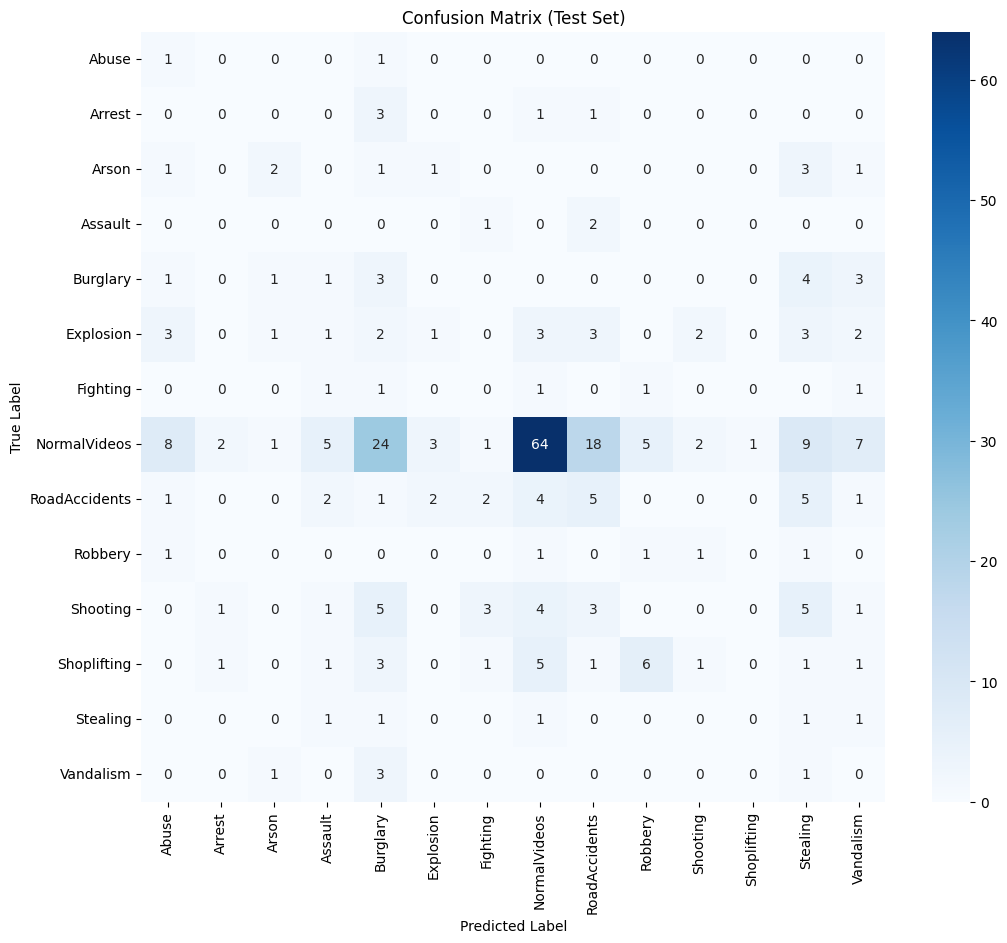


Classification Report (Test Set):
               precision    recall  f1-score   support

        Abuse       0.06      0.50      0.11         2
       Arrest       0.00      0.00      0.00         5
        Arson       0.33      0.22      0.27         9
      Assault       0.00      0.00      0.00         3
     Burglary       0.06      0.23      0.10        13
    Explosion       0.14      0.05      0.07        21
     Fighting       0.00      0.00      0.00         5
 NormalVideos       0.76      0.43      0.55       150
RoadAccidents       0.15      0.22      0.18        23
      Robbery       0.08      0.20      0.11         5
     Shooting       0.00      0.00      0.00        23
  Shoplifting       0.00      0.00      0.00        21
     Stealing       0.03      0.20      0.05         5
    Vandalism       0.00      0.00      0.00         5

     accuracy                           0.27       290
    macro avg       0.12      0.15      0.10       290
 weighted avg       0.43    

In [9]:
# Path to your checkpoint directory
checkpoint_dir = r"C:\Users\rayaa\Downloads\ucf_crime\crime_type_checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "epoch_10.pt")  # adjust filename

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load weights properly
model.load_state_dict(checkpoint["model_state_dict"])

print(f"✅ Loaded model weights from: {checkpoint_path} (epoch {checkpoint.get('epoch', '?')})")

# ============================================
# Evaluation
# ============================================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for clips, labels in tqdm(test_loader, desc="Evaluating"):
        clips, labels = clips.to(device).float(), labels.to(device)
        outputs = model(pixel_values=clips)
        preds = outputs.logits.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

labels_arr = np.arange(num_classes)
class_names = [cls for cls, _ in sorted(test_dataset.class_to_idx.items(), key=lambda x: x[1])]

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=labels_arr)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(all_labels, all_preds, labels=labels_arr, target_names=class_names))

# Overall accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"Overall Test Accuracy: {acc:.4f}")
